# Processing Images with OpenCV

Sooner or later, when working with images, you will find you need to alter them: be it identifying ROI, blending 2 images, apply basic transformation, and even draw shapes on image. Our discussion and code samples will cover the following topics:

- cropping images
- image blending
- basic geometric transformations: translation, rotation, custom affine transformation.
- image annotations (e.g. circle, rectangle, straight line, ellipse, text)
- bitwise operations

## Setup

In [30]:
import sys
# Python 3.7 is required
assert sys.version_info >= (3,7)

import cv2 as cv
import numpy as np

# Make sure that optimization is enabled
if not cv.useOptimized():
    cv.setUseOptimized(True)

cv.useOptimized()

True

### Define the regions of interests (ROI)
Sometimes, we will have to play with a certain region of images. ROI is obtained by using Numpy indexing / slicing.

In [31]:
img = cv.imread('lena.jfif')
my_roi = img[:50, :50]
img[150:200, 150:200] = my_roi

cv.imshow('ROI_copy', img)
cv.waitKey(0)
cv.destroyAllWindows()

In [32]:
img.shape

(225, 225, 3)

In [33]:
img.dtype

dtype('uint8')

## Cropping an image
Why crop an image? 
1. Remove all unwanted objects or areas from an image
2. Change the aspect rato of an image
3. Improve the overall composition of the image. Visit this [link](https://expertphotography.com/improve-your-composition-the-rule-of-thirds/) on how separating image into grids and putting the subject of interest on the intersection point could create a more compositional pleasing photo. This is known as of rule of thirds.

The operations are literally the same as extracting ROI.

In [26]:
img = cv.imread('dog.jfif')
print(img.shape)

cv.imshow("original", img)
cropped_img = img[25:85, 100:200]
cv.imshow('cropped_img', cropped_img)

cv.waitKey(0)
cv.destroyAllWindows()

(168, 300, 3)


In [27]:
cropped_img.shape

(60, 100, 3)

<a id="Section1"></a>
    
### Divide an image into smaller patches using cropping
One practical application of cropping in OpenCV is to divide an image into smaller patches. The following example shows how to split image into a $2 \times 3$ grid.

In [ ]:
img = cv.imread('dog.jfif')
img_copy = img.copy()

height, width = img.shape[:2]
num_horizontal_patches = 2
num_vertical_patches = 3

# M and N are basically number of pixels per patch
M, N = int(height/num_horizontal_patches), int(width/num_vertical_patches)

x1, y1 = 0, 0

for y in range(0, height, M):
    for x in range(0, width, N):
#         if (height - y) < M or (width - x) < N:
#             break
            
        y1 = y + M    # lower right coordinate that will be used to construct rectangle
        x1 = x + N
        
        # Check whether patch lower right coordinate exceeds image height and width
        if x1 >= width and y1 >= height:
            x1 = width - 1
            y1 = height - 1
            tile = img[y:height, x:width]
            cv.rectangle(img_copy, (x, y), (x1, y1), (0, 255, 0), 1)
            cv.imshow('tile', tile)
        # When patch lower right y-coordinate exceeds patch height
        elif y1 >= height:
            y1 = height - 1
            cv.rectangle(img_copy, (x, y), (x1, y1), (0, 255, 0), 1)
            
        # When patch lower right x-coordinate exceeds patch width
        elif x1 >= width:
            x1 = width - 1
            cv.rectangle(img_copy, (x, y), (x1, y1), (0, 255, 0), 1)
        
        else:
            cv.rectangle(img_copy, (x, y), (x1, y1), (0, 255, 0), 1)

cv.imshow('patched image', img_copy)
cv.waitKey(0)
cv.destroyAllWindows()

## Swapping regions (exercise)
1. Divide the image into 4 equal regions. Swap their positions as shown below:  ![dog_swap](image_embed/crop_swap.PNG "dog")
2. Cover the face of lena with white mask as shown as the following:  ![lena_mask](image_embed/lena_mask.PNG "lena mask")

## Splitting and merging Image channels
The B, G and R channels can be split into their individual planes when needed. Then the individual channels can be merged back together to form BGR image again. The splitting and merging operations can be attained by the following functions respectively:
* `cv.split(m)`, where m is a multi-channel array.
* `cv.merge(mv)`, where mv is a vector of matrices to be merged; all the matrices in mv must have the same size and the same depth (precision of each pixel).

In [14]:
b,g,r = cv.split(img)
img = cv.merge((b,g,r))

In [15]:
# Alternative to split channel: index slicing
# Access the green channel matrix
g = img[:, :, 1]

### Exercise
2. Display the blue, green and red channel of the **lena** image simultaneously. Comment on the images displayed.

## Image blending

Have you ever wonder what you would end up with if you add two images up? The resulting image will give you an impression of <mark>transparency</mark>. 

This is image addition, but different weights are given to images so that it gives a feeling of blending or transparency. </br>
$ g(x) = (1 - \alpha)f_{0}(x) + (\alpha)f_{1}(x) $  
By varying $ \alpha $ from 0 to 1, we can perform cool transition from one image to another. The associated function is 
```python
cv.addWeighted(src1, alpha, src2, beta, gamma)
```
1. First argument, src1 is the first input array.
2. alpha is the weight of the first array elements.
3. src2 is the second input array of the same size and channel number as src1.
4. beta is the weight of the second array elements. 
5. gamma is the scalar added to each sum.

There is a catch here: **Make sure both images are of the same dimension**.

In [16]:
img1 = cv.imread('lena.jpg')
img2 = cv.imread('coins.jfif')

# Resize img2
new_shape = img1.shape[:2]
img2 = cv.resize(img2, new_shape)

dst = cv.addWeighted(img1, 0.75, img2, 0.25, 0)

cv.imshow('image1', img1)
cv.imshow('reshape_image2', img2)
cv.imshow('blend_image', dst)
cv.waitKey(0)
cv.destroyAllWindows()

## Affine transformation operations

Rotation and translation of images are among the most fundamental operations in image editing. Both fall under the broader class of *Affine transformation*. Affine transformation is a linear mapping method that preserves points, straight lines, and planes. Sets of parallel lines remain parallel after an affine transformation. Mathematically speaking, a transformation that can be expressed in the form of matrix multiplication (linear combination) followed by vector addition (translation).

The affine transformation is typically used to correct for geometric distortions or deformations caused by non-ideal camera angles.

### Rotation 
Two key functions:
- `cv.getRotationMatrix2D(center, angle, scale)`
    1. First argument is the center of rotation (coordinates, which is expressed as tuple).
    2. Second argument is angle of rotation in degrees.
    3. scale: scale factor which scales the image up or down.
- `cv.warpAffine(src, M, dsize, ...)`
    1. First argument is the source image.
    2. M is the transformation matrix (output of the `cv.getRotationMatrix2D()` function. 
    3. dsize is size of output image. 
... denotes optional arguments. For the complete list of arguments, visit the online [OpenCV documentation](https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#ga0203d9ee5fcd28d40dbc4a1ea4451983)

### Translation
- Create transformation matrix, which is a 2x3 array.
- Call `cv.warpAffine()` function.

#### Rotation

In [17]:
img = cv.imread('lena.jfif')
rows, cols = img.shape[:2]
M = cv.getRotationMatrix2D(((cols-1)/2.0, (rows-1)/2.0), 90, 1)
dst = cv.warpAffine(img, M, (cols, rows))

cv.imshow('rotated_image', dst)
cv.waitKey(0)
cv.destroyAllWindows()

In [11]:
dst.shape

(225, 225, 3)

#### Translation

In [18]:
rows, cols = img.shape[:2]

M = np.float32([[1, 0, 100], [0, 1, 50]])
dst = cv.warpAffine(img, M, (cols, rows))
# The third argument of cv.warpAffine is the size of outpt image

cv.namedWindow('translated_image')
cv.imshow('translated_image', dst)
cv.waitKey(0)
cv.destroyAllWindows()

### Exercise
3. Rotate and translate any image.

#### Scaling
Scaling is just resizing of the image.

In [19]:
img = cv.imread('lena.jpg')
res = cv.resize(img, None, fx = 2, fy = 2, interpolation = cv.INTER_CUBIC)

# 0R
# height, width = img.shape[:2]
# res = cv.resize(img, (2*width, 2*height), interpolation = cv.INTER_CUBIC)

cv.imshow('resize_lena', res)
cv.waitKey(0)
cv.destroyAllWindows()

#### OpenCV affine transformation function
In affine transformation, all parallel lines in the original image will still be parallel in the output image. To find the transformation matrix, we need 3 points from the input image and their corresponding locations in the output image. When it comes to the implementation part, similar to rotation, two OpenCV functions are needed: `cv.getAffineTransform()` to get the $2 \times 3$ matrix, in which this matrix will be argument for `cv.warpAffine()`.
```python
# Calculates affine transform from 3 pairs of the corresponding points
cv.getAffineTransform(src, dst)
```
1. First argument is coordinates of triangle vertices in the source image.
2. Coordinates of the corresponding triangle vertices in the destination image.

```python
cv.warpAffine(src, M, dsize, ...)
```
1. First argument, src is the input image.
2. M is the $2 \times 3$ transformation matrix.
3. dsize is the size of the output image. Usually, same as the input image size.

In [20]:
import matplotlib.pyplot as plt

In [22]:
img = cv.imread('chessboard.png')

# change to RGB
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img.shape

(213, 213, 3)

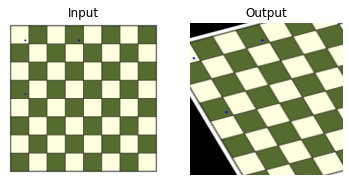

In [23]:
rows, cols = img.shape[:2]

pts1 = np.float32([[25, 25], [100, 25], [25, 100]])
pts2 = np.float32([[5, 50], [100, 25], [50, 125]])

for pt in pts1:
    cv.circle(img, (int(pt[0]), int(pt[1])), 1, (0, 0, 255), -1)

M = cv.getAffineTransform(pts1, pts2)
dst = cv.warpAffine(img, M, (cols, rows))

for pt in pts2:
    cv.circle(dst, (int(pt[0]), int(pt[1])), 1, (0, 0, 255), -1)

plt.subplot(121), plt.imshow(img), plt.title('Input'), plt.axis('off')
plt.subplot(122), plt.imshow(dst), plt.title('Output'), plt.axis('off')
plt.show()

## Annotating Images using OpenCV
Why image annotations? Below are some of the use cases:
- Adding information to your images.
- Drawing bounding boxes around objects for the purpose of object detection.

Once you learn to annotate images, annotating video frames will seem just easy. That's because each frame in a video is represented as an image. 

### Draw line on image
The associated function is `cv.line()`
```python
cv.line(img, pt1, pt2, color, thickness, lineType, shift)
```
1. First argument, img is the source image
2. pt1 is the first point of the line segment.
3. pt3 is the second point of the line segment.
4. linetype is optional flags. Examples are:
    - cv.FILLED
    - cv.LINE_4
    - cv.LINE_8
    - cv.LINE_AA

In [24]:
img = cv.imread('dog.jfif')
if img is None:
    print('Could not read image')

# Draw line on an image
start_point = (50, 25)
end_point = (80, 100)
cv.line(img, start_point, end_point, (255, 255, 0), 2, cv.LINE_AA)

cv.imshow('Line', img)
cv.waitKey(0)
cv.destroyAllWindows()

### Draw circle

The function is `cv.cirle()`.
```python
cv.circle(img, center, radius, color, thickness, lineType, shift)
```
1. First argument, img is similar to `cv.line()`, refer to source image.
2. Center is the center coordinates of the circle.

In [25]:
img_copy = img.copy()
center = (145, 50)

cv.circle(img_copy, center, 40, (0, 0, 255), 2, cv.LINE_AA)
cv.imshow('circle', img_copy)
cv.waitKey(0)
cv.destroyAllWindows()

In [26]:
# filled circle
img = cv.imread('dog.jfif')
img_copy = img.copy()

cv.circle(img_copy, center, 40, (0, 255, 0), -1, cv.LINE_AA)
cv.imshow('filled circle', img_copy)
cv.waitKey(0)
cv.destroyAllWindows()

### Draw rectangle
The function is `cv.rectangle()`.
```python
cv.rectangle(img, pt1, pt2, color, thickness, linetype, shift)
```
1. First argument, img is the source image.
2. pt1 is the vertex / corner of rectangle.
3. pt2 is the opposite vertex / corner of rectangle. Together, pt1 and pt2 form the diagonal of the rectangle.

In [27]:
img_copy = img.copy()
pt1 = (100, 10)
pt2 = (190, 90)

cv.rectangle(img_copy, pt1, pt2, (255, 0, 0), 3, cv.LINE_AA)
cv.imshow('rectangle', img_copy)
cv.waitKey(0)
cv.destroyAllWindows()

### Draw ellipse
The function is `cv.ellipse()`.
```python
cv.ellipse(img, center, axes, angle, startAngle, endAngle, color, ...)
```
1. First argument, img is the source image.
2. center is the center coordinates of ellipse.
3. axes is a tuple of half the axes (major & minor) lengths.
4. angle is the rotation angle. Both axes and angle arguments will determine if the output is a *horizontal* ellipse or a *vertical* ellipse.
5. If we want to draw full ellipse, then set `startAngle = 0` and `endAngle = 360`.

In [28]:
img_copy = img.copy()
center = (145, 50)
axes = (50, 25)

cv.ellipse(img_copy, center, axes, 0, 0, 360, (0, 255, 0), 2)
cv.imshow('ellipse', img_copy)
cv.waitKey(0)
cv.destroyAllWindows()

### Text annotation
The function is `cv.putText()` function.
```python
cv.putText(img, text, org, fontFace, fontScale, color, ...)
```
1. First argument, img is the source image.
2. text is the text string to be inserted.
3. org is the bottom left corner coordinates of the text string.
4. fontFace is the font type. For more info, please see [this webpage](https://docs.opencv.org/4.x/d6/d6e/group__imgproc__draw.html#ga0f9314ea6e35f99bb23f29567fc16e11).
5. fontScale is the font scale factor. 

In [29]:
img_copy = img.copy()

text = 'My name is Bobby!'
org = (15, 150)

cv.putText(img_copy, text, org, 0, 0.8, (0, 255, 100), 2)
cv.imshow('image with text', img_copy)
cv.waitKey(0)
cv.destroyAllWindows()

## Exercise 4: Drawing functions
Draw a bulleye image like what shown below:  
![bulleye](image_embed/bulleye.PNG "bulleye")

## Bitwise operations
In this section, we will review four bitwise operations: _AND_, _OR_, _XOR_, and _NOT_. While very basic and low level, these 4 operations are indispensible, when it comes to masking. 

Bitwise operations function in a binary manner. A given pixel is turned off it has a value of zero and it is turned on if the pixel has a value greater than zero.
```python
dst = cv.bitwise_and(src1, src2[, dst[, mask]])
```
The first and second arguments are input array (images). Argument 'mask' is optional operation mask. `cv.bitwise_or` and `cv.bitwise_xor` method signature are similar to `cv.bitwise_and`.

```python
dst = cv.bitwise_not(src[, dst[, mask]])
```
The first argument is the input array, while argument 'mask' is optional operation mask. 

In [31]:
# draw a rectangle on a dark background
rect = np.zeros((400, 400), dtype = np.uint8)
cv.rectangle(rect, (30, 30), (370, 370), 255, -1)
cv.imshow('rectangle', rect)
# draw a circle on a dark background
circle = np.zeros((400, 400), dtype = np.uint8)
cv.circle(circle, (200, 200), 200, 255, -1)
cv.imshow('circle', circle)

cv.waitKey(0)
cv.destroyAllWindows()

In [32]:
# Perform bitwise operation: AND
res_AND = cv.bitwise_and(rect, circle)
cv.imshow('AND operator result', res_AND)
cv.waitKey(0)
cv.destroyAllWindows()

In [33]:
# Perform bitwise operation: OR
res_OR = cv.bitwise_or(rect, circle)
cv.imshow('OR operator result', res_OR)
cv.waitKey(0)
cv.destroyAllWindows()

In [34]:
# Perform bitwise operation: XOR
res_XOR = cv.bitwise_xor(rect, circle)
cv.imshow('XOR operator result', res_XOR)
cv.waitKey(0)
cv.destroyAllWindows()

**Exercise**  
5. Turn the white rectangle on dark background to black rectangle on white background.

## Weekly activity

1. Convert the code chunk found under section <a href="#Section1">Divide an image into smaller patches using cropping</a> into a function with the following signature:
```python
crop_grid(img, num_horizontal_grid, num_vertical_grid, line_color)
 # img is the source image
 # num_horizontal_grid and num_vertical_grid are the number of patches along x and y axes.
 # line_color is the color of the grid line.
 # The output of the function should be image with grids
```
2. Display image sequences of smooth transition of two images with different values of $\alpha$. Refer to code in section "Image blending". Use _"lena.jfif"_ and *"coins.jfif"* as the base images. 
3. Rotate image by 45 degrees without cropping the sides of the image. (Hint: There are 2 strategies to tackle these problems). Use _"lena.jfif"_ as the input image.
    - Use external libraries `imutils`.  
    - Modify the transformation matrix.
4. Use the images with titles: _"flower.jfif"_ and *"native-bee.png"*. I want to put flower above an image. If I add two images, it will change color. If I blend it, I get a transparent effect. But I want it to be opaque. If it was a rectangular region, we could use the ROI as we did in the previous section. But flower is not a rectangular region. This is where bitwise operations, like AND, OR, NOT and XOR really come in handy. The associated functions are `cv.bitwise_and()`, `cv.bitwise_or()` and `cv.bitwise_not()`. You need to use `cv.threshold` function to segment the flower. Please refer to [online documentation](https://docs.opencv.org/4.x/d2/de8/group__core__array.html#ga60b4d04b251ba5eb1392c34425497e14) for more info. The result should resemble the following:  
![bee and flowers](image_embed/activity3.PNG "bee_flower")